In [1]:
%matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import params, trades, feats, plots, models_core
from libs.models import dual_lstm
importlib.reload(params)
importlib.reload(trades)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)
importlib.reload(dual_lstm)

<module 'libs.models.dual_lstm' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models/dual_lstm.py'>

In [2]:
# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
matplotlib.use("Agg")  # safe, headless-friendly
import matplotlib.pyplot as plt
plt.ioff()

import os
import json
import numpy as np
import pandas as pd
import datetime as dt
from pathlib import Path

from torch import nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
from torch.cuda.amp import GradScaler, autocast

import optuna
from optuna.pruners import MedianPruner
from optuna.exceptions import TrialPruned
from optuna.importance import get_param_importances

from tqdm.auto import tqdm


In [3]:
df_feat_sel = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True)[params.features_cols_tick + ['close_raw'] + [params.label_col]]
    
df_feat_sel

,sma_pct_14,atr_pct_14,rsi_14,bb_w_20,plus_di_14,range_pct,eng_ma,minus_di_14,macd_diff_12_26_9,ret,eng_macd,macd_line_12_26_9,obv_diff_14,eng_atr_div,eng_adx,hour,adx_14,close_raw,signal
2004-01-02 09:33:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.301415e-09
2004-01-02 09:34:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.405474e-09
2004-01-02 09:35:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.517855e-09
2004-01-02 09:36:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.639221e-09
2004-01-02 09:37:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.770291e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.751690,0.323886,0.672166,0.273759,0.363125,0.254109,0.532431,0.074852,0.888941,0.642346,0.634772,0.971125,1.000000,0.664288,0.537709,-0.975989,0.301944,196.815000,6.849078e-01
2025-06-18 20:57:00,0.650094,0.336016,0.616686,0.290460,0.347207,0.420131,0.532016,0.067044,0.840741,0.340442,0.633511,0.981544,0.000000,0.676887,0.541855,-0.975989,0.328685,196.675000,6.122057e-01
2025-06-18 20:58:00,0.631153,0.322169,0.614734,0.304199,0.336272,0.121620,0.531618,0.064933,0.777896,0.494192,0.631866,0.983006,0.000000,0.584662,0.545337,-0.975989,0.353515,196.670000,6.104678e-01
2025-06-18 20:59:00,0.375519,0.346959,0.475401,0.305249,0.290578,0.565110,0.531157,0.160021,0.456523,0.009795,0.623450,0.884486,0.000000,0.645760,0.531521,-0.975989,0.348960,196.240000,4.770902e-01


In [4]:
# calculate look_backs under half the interval between the day’s first and sess_start

first_time = (
    df_feat_sel.index
        .to_series()
        .groupby(df_feat_sel.index.normalize())
        .min()
        .dt.time
        .mode()[0]
)

# convert both times to minutes since midnight
fm = first_time.hour * 60 + first_time.minute
sm = params.sess_start.hour * 60 + params.sess_start.minute

# half the difference, count full 30-min slots, and build multiples
n_steps    = int(((sm - fm) / 2) // 30)      # e.g. floor(165/30) = 5
look_backs = [30 * i for i in range(1, n_steps + 1)]
look_backs


[30, 60, 90, 120]

In [5]:
# ──────────────────────────────────────────────────────────────────────────────
# Optuna objective definition
# ──────────────────────────────────────────────────────────────────────────────

look_backs = [60, 75, 90] ################################

def objective(trial):
    
    hp = {
    # ── Architecture ────────────────────────────────────────────────
    "look_back"    : trial.suggest_categorical("look_back", look_backs),
    "DROPOUT_SHORT": trial.suggest_float("DROPOUT_SHORT", 0.25, 0.30),
    "DROPOUT_LONG":  trial.suggest_float("DROPOUT_LONG",  0.30, 0.35),
    "ATT_DROPOUT":   trial.suggest_float("ATT_DROPOUT",   0.20, 0.25),
    
    # ── Optimizer & Scheduler ──────────────────────────────────────
    "INITIAL_LR":    trial.suggest_float("INITIAL_LR",    7e-5, 1e-4,   log=True),
    "ETA_MIN":       trial.suggest_float("ETA_MIN",       1e-6, 1e-5,   log=True),
    "WEIGHT_DECAY":  trial.suggest_float("WEIGHT_DECAY",  1e-3, 1e-5,  log=True),
    "CLIPNORM":      trial.suggest_float("CLIPNORM",      0.5, 1),
    }

    print(f"\n▶ Trial {trial.number} starting with:\n{hp}\n")

    sess_start_pred = dt.time(*divmod((params.sess_start.hour * 60 + params.sess_start.minute) - hp["look_back"], 60))
    
    print('Build LSTM input tensors...')
    X, y_sig, y_ret, raw_close, end_times = models_core.build_tensors(
        df            = df_feat_sel,
        sess_start    = sess_start_pred 
    )
    
    print('Split into train/val/test by calendar day...')
    (
    (X_tr,  y_sig_tr,  y_ret_tr),
    (X_val, y_sig_val, y_ret_val),
    (X_te,  y_sig_te,  y_ret_te,  raw_close_te),
    samples_per_day,
    day_id_tr, day_id_val, day_id_te
    ) = models_core.chronological_split(
        X, y_sig, y_ret, raw_close,
        end_times   = end_times,
        train_prop  = params.train_prop,
        val_prop    = params.val_prop,
        train_batch = params.hparams['TRAIN_BATCH']
    )

    print('Carve `end_times` into the same three splits...')
    n_tr  = day_id_tr .shape[0] 
    n_val = day_id_val.shape[0]
    i_tr  = n_tr
    i_val = n_tr + n_val
    
    end_times_tr  = end_times[:i_tr]
    end_times_val = end_times[i_tr:i_val]
    end_times_te  = end_times[i_val:]
    
    print('Build DataLoaders over calendar‐days...')
    train_loader, val_loader, test_loader = models_core.split_to_day_datasets(
        # train split:   
        X_tr,       y_sig_tr,     y_ret_tr,   end_times_tr,
        # val split:
        X_val,      y_sig_val,    y_ret_val,  end_times_val,
        # test split + raw‐prices
        X_te,       y_sig_te,     y_ret_te,   end_times_te,    raw_close_te, 
        
        sess_start_time       = sess_start_pred,
        signal_thresh         = params.best_optuna_params["buy_threshold"],
        return_thresh         = 0.01,  # flat‐zone threshold for returns (to tune)
        train_batch           = params.hparams["TRAIN_BATCH"],
        train_workers         = params.hparams["NUM_WORKERS"],
        train_prefetch_factor = params.hparams["TRAIN_PREFETCH_FACTOR"]
    )

    print('Instantiate the stateful DualMemoryLSTM...')
    model = dual_lstm.DualMemoryLSTM(
        n_feats        = X.shape[-1],                          
        short_units    = params.hparams['SHORT_UNITS'],    
        long_units     = params.hparams['LONG_UNITS'],     
        dropout_short  = hp["DROPOUT_SHORT"],  
        dropout_long   = hp["DROPOUT_LONG"],   
        att_heads      = params.hparams['ATT_HEADS'],
        att_drop       = hp['ATT_DROPOUT']
    )
    model.to(params.device)  

    print('Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...')
    optimizer, plateau_sched, _ , scaler, clipnorm = \
        models_core.make_optimizer_and_scheduler(
            model            = model,
            initial_lr       = hp["INITIAL_LR"],
            weight_decay     = hp["WEIGHT_DECAY"],
            clipnorm         = hp["CLIPNORM"]
        )
    cosine_sched = CosineAnnealingWarmRestarts(
        optimizer, 
        T_0=params.hparams['T_0'], 
        T_mult=params.hparams['T_MULT'], 
        eta_min=hp['ETA_MIN']
    )
    
    print('Run the custom stateful training loop...')
    best_val_rmse  = dual_lstm.lstm_training_loop(
        model               = model,
        optimizer           = optimizer,
        cosine_sched        = cosine_sched,
        plateau_sched       = plateau_sched,
        scaler              = scaler,
        train_loader        = train_loader,
        val_loader          = val_loader,
        max_epochs          = params.hparams['MAX_EPOCHS'],
        early_stop_patience = params.hparams['EARLY_STOP_PATIENCE'],
        clipnorm            = hp["CLIPNORM"],
        device              = params.device
    )

    print('Delete variables to free memory...')
    del model, optimizer, plateau_sched, cosine_sched, scaler
    del X, y_sig, y_ret, raw_close, raw_close_te
    del X_tr,  y_sig_tr,  y_ret_tr, X_val, y_sig_val, y_ret_val, X_te,  y_sig_te,  y_ret_te
    del train_loader, val_loader, test_loader

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    return best_val_rmse


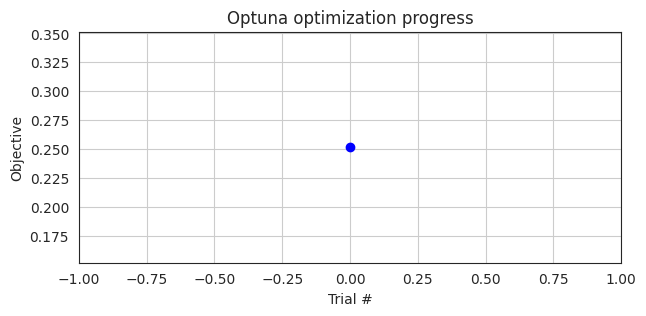

In [6]:
# build blank figure & line
fig, ax = plt.subplots(figsize=(7,3))
line, = ax.plot([], [], "bo-")
ax.set(xlabel="Trial #", ylabel="Objective",
       title="Optuna optimization progress")
ax.grid(True)

# display once and grab the handle
handle = display(fig, display_id=True)
plt.close(fig)

# ask plots.py for a callback bound to these objects
live_cb = plots.make_live_plot_callback(fig, ax, line, handle)

[I 2025-09-25 10:18:04,995] A new study created in RDB with name: no-name-ff238292-70f4-4a33-bf50-780c1813fab0



▶ Trial 0 starting with:
{'look_back': 75, 'DROPOUT_SHORT': 0.27752041129802435, 'DROPOUT_LONG': 0.30750251065728185, 'ATT_DROPOUT': 0.24948186354866914, 'INITIAL_LR': 9.094068223316255e-05, 'ETA_MIN': 2.247584976810896e-06, 'WEIGHT_DECAY': 0.0016867216338959851, 'CLIPNORM': 0.5171703013630076}

Build LSTM input tensors...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Preparing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


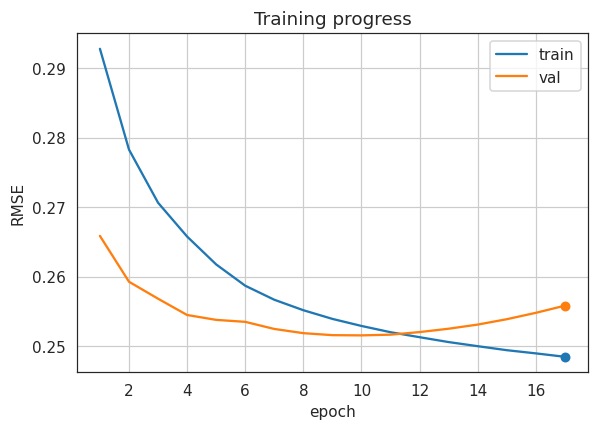

Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2928 MAE=0.2241 R2=-0.0178 | Acc=0.6804 Prec=0.3613 Rec=0.2140 F1=0.2688 AUROC=0.5907
VALID→ RMSE=0.2658 MAE=0.1853 R2=0.1381 | Acc=0.7235 Prec=0.7503 Rec=0.0404 F1=0.0767 AUROC=0.6956


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2783 MAE=0.2131 R2=0.0806 | Acc=0.7126 Prec=0.4364 Rec=0.1604 F1=0.2346 AUROC=0.5911
VALID→ RMSE=0.2593 MAE=0.1863 R2=0.1803 | Acc=0.7335 Prec=0.7853 Rec=0.0854 F1=0.1541 AUROC=0.7323


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2706 MAE=0.2075 R2=0.1304 | Acc=0.7312 Prec=0.5321 Rec=0.1716 F1=0.2595 AUROC=0.6370
VALID→ RMSE=0.2568 MAE=0.1863 R2=0.1957 | Acc=0.7448 Prec=0.7370 Rec=0.1585 F1=0.2609 AUROC=0.7412


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2658 MAE=0.2036 R2=0.1614 | Acc=0.7402 Prec=0.5666 Rec=0.2278 F1=0.3250 AUROC=0.6757
VALID→ RMSE=0.2545 MAE=0.1868 R2=0.2103 | Acc=0.7506 Prec=0.7079 Rec=0.2084 F1=0.3220 AUROC=0.7439


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2617 MAE=0.2006 R2=0.1865 | Acc=0.7475 Prec=0.5922 Rec=0.2574 F1=0.3589 AUROC=0.7008
VALID→ RMSE=0.2538 MAE=0.1869 R2=0.2146 | Acc=0.7539 Prec=0.6921 Rec=0.2412 F1=0.3578 AUROC=0.7441


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2587 MAE=0.1977 R2=0.2055 | Acc=0.7526 Prec=0.6088 Rec=0.2764 F1=0.3802 AUROC=0.7178
VALID→ RMSE=0.2535 MAE=0.1864 R2=0.2164 | Acc=0.7559 Prec=0.6844 Rec=0.2615 F1=0.3784 AUROC=0.7438


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2567 MAE=0.1958 R2=0.2178 | Acc=0.7557 Prec=0.6177 Rec=0.2888 F1=0.3936 AUROC=0.7283
VALID→ RMSE=0.2525 MAE=0.1870 R2=0.2227 | Acc=0.7566 Prec=0.6702 Rec=0.2824 F1=0.3974 AUROC=0.7435


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2552 MAE=0.1946 R2=0.2270 | Acc=0.7574 Prec=0.6200 Rec=0.3009 F1=0.4051 AUROC=0.7357
VALID→ RMSE=0.2519 MAE=0.1876 R2=0.2264 | Acc=0.7567 Prec=0.6620 Rec=0.2938 F1=0.4069 AUROC=0.7434


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2539 MAE=0.1935 R2=0.2345 | Acc=0.7591 Prec=0.6240 Rec=0.3082 F1=0.4126 AUROC=0.7414
VALID→ RMSE=0.2516 MAE=0.1880 R2=0.2282 | Acc=0.7564 Prec=0.6531 Rec=0.3042 F1=0.4151 AUROC=0.7434


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2529 MAE=0.1926 R2=0.2406 | Acc=0.7603 Prec=0.6261 Rec=0.3149 F1=0.4190 AUROC=0.7456
VALID→ RMSE=0.2515 MAE=0.1883 R2=0.2284 | Acc=0.7560 Prec=0.6466 Rec=0.3118 F1=0.4207 AUROC=0.7433


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.2520 MAE=0.1918 R2=0.2461 | Acc=0.7615 Prec=0.6285 Rec=0.3210 F1=0.4250 AUROC=0.7489
VALID→ RMSE=0.2516 MAE=0.1892 R2=0.2278 | Acc=0.7555 Prec=0.6378 Rec=0.3230 F1=0.4288 AUROC=0.7432


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ RMSE=0.2513 MAE=0.1912 R2=0.2503 | Acc=0.7622 Prec=0.6290 Rec=0.3259 F1=0.4294 AUROC=0.7514
VALID→ RMSE=0.2520 MAE=0.1902 R2=0.2255 | Acc=0.7545 Prec=0.6285 Rec=0.3326 F1=0.4350 AUROC=0.7428


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ RMSE=0.2506 MAE=0.1905 R2=0.2545 | Acc=0.7628 Prec=0.6300 Rec=0.3294 F1=0.4327 AUROC=0.7534
VALID→ RMSE=0.2525 MAE=0.1910 R2=0.2225 | Acc=0.7538 Prec=0.6228 Rec=0.3388 F1=0.4388 AUROC=0.7424


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ RMSE=0.2500 MAE=0.1899 R2=0.2580 | Acc=0.7638 Prec=0.6324 Rec=0.3333 F1=0.4365 AUROC=0.7557
VALID→ RMSE=0.2531 MAE=0.1917 R2=0.2188 | Acc=0.7528 Prec=0.6168 Rec=0.3434 F1=0.4412 AUROC=0.7419


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ RMSE=0.2494 MAE=0.1895 R2=0.2615 | Acc=0.7644 Prec=0.6336 Rec=0.3360 F1=0.4391 AUROC=0.7573
VALID→ RMSE=0.2539 MAE=0.1924 R2=0.2140 | Acc=0.7518 Prec=0.6121 Rec=0.3456 F1=0.4418 AUROC=0.7409


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ RMSE=0.2489 MAE=0.1891 R2=0.2642 | Acc=0.7648 Prec=0.6343 Rec=0.3384 F1=0.4413 AUROC=0.7586
VALID→ RMSE=0.2548 MAE=0.1932 R2=0.2083 | Acc=0.7505 Prec=0.6060 Rec=0.3491 F1=0.4430 AUROC=0.7398


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ RMSE=0.2485 MAE=0.1887 R2=0.2671 | Acc=0.7656 Prec=0.6369 Rec=0.3404 F1=0.4437 AUROC=0.7602
VALID→ RMSE=0.2558 MAE=0.1940 R2=0.2019 | Acc=0.7491 Prec=0.5994 Rec=0.3525 F1=0.4439 AUROC=0.7384
Early stopping at epoch 17
✅ Final best model (_fin) saved: AAPL_0.25153_fin.pth
Delete variables to free memory...


[I 2025-09-25 10:37:13,383] Trial 0 finished with value: 0.25153419375419617 and parameters: {'look_back': 75, 'DROPOUT_SHORT': 0.27752041129802435, 'DROPOUT_LONG': 0.30750251065728185, 'ATT_DROPOUT': 0.24948186354866914, 'INITIAL_LR': 9.094068223316255e-05, 'ETA_MIN': 2.247584976810896e-06, 'WEIGHT_DECAY': 0.0016867216338959851, 'CLIPNORM': 0.5171703013630076}. Best is trial 0 with value: 0.25153419375419617.



▶ Trial 1 starting with:
{'look_back': 60, 'DROPOUT_SHORT': 0.29072975465470663, 'DROPOUT_LONG': 0.3283484814730205, 'ATT_DROPOUT': 0.215050363916267, 'INITIAL_LR': 8.057626123197634e-05, 'ETA_MIN': 6.6545508962106075e-06, 'WEIGHT_DECAY': 0.0023785654866553684, 'CLIPNORM': 0.8511807751418623}

Build LSTM input tensors...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Preparing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


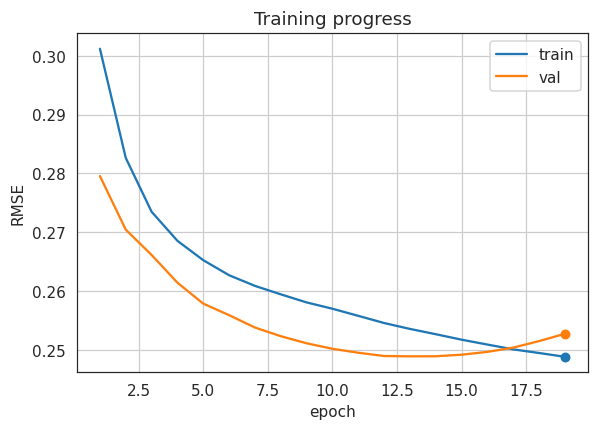

Epoch 1:   0%|          | 0/60 [00:01<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.3012 MAE=0.2297 R2=-0.0751 | Acc=0.6754 Prec=0.3580 Rec=0.2184 F1=0.2713 AUROC=0.5797
VALID→ RMSE=0.2795 MAE=0.1912 R2=0.0513 | Acc=0.7127 Prec=0.4915 Rec=0.0006 F1=0.0012 AUROC=0.6507


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2826 MAE=0.2158 R2=0.0533 | Acc=0.7082 Prec=0.3988 Rec=0.1080 F1=0.1700 AUROC=0.5732
VALID→ RMSE=0.2704 MAE=0.1881 R2=0.1122 | Acc=0.7153 Prec=0.8648 Rec=0.0108 F1=0.0214 AUROC=0.7102


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2735 MAE=0.2085 R2=0.1136 | Acc=0.7246 Prec=0.5079 Rec=0.1453 F1=0.2260 AUROC=0.6246
VALID→ RMSE=0.2661 MAE=0.1861 R2=0.1402 | Acc=0.7300 Prec=0.7824 Rec=0.0833 F1=0.1506 AUROC=0.7258


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2685 MAE=0.2047 R2=0.1454 | Acc=0.7354 Prec=0.5568 Rec=0.2125 F1=0.3076 AUROC=0.6626
VALID→ RMSE=0.2614 MAE=0.1848 R2=0.1704 | Acc=0.7407 Prec=0.7371 Rec=0.1515 F1=0.2514 AUROC=0.7304


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2652 MAE=0.2024 R2=0.1662 | Acc=0.7425 Prec=0.5795 Rec=0.2527 F1=0.3520 AUROC=0.6840
VALID→ RMSE=0.2579 MAE=0.1846 R2=0.1929 | Acc=0.7462 Prec=0.7114 Rec=0.1960 F1=0.3073 AUROC=0.7333


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2627 MAE=0.2001 R2=0.1822 | Acc=0.7473 Prec=0.5987 Rec=0.2629 F1=0.3654 AUROC=0.6974
VALID→ RMSE=0.2559 MAE=0.1844 R2=0.2051 | Acc=0.7491 Prec=0.6980 Rec=0.2232 F1=0.3382 AUROC=0.7359
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25589_chp.pth


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2609 MAE=0.1985 R2=0.1934 | Acc=0.7505 Prec=0.6117 Rec=0.2687 F1=0.3733 AUROC=0.7069
VALID→ RMSE=0.2538 MAE=0.1845 R2=0.2181 | Acc=0.7510 Prec=0.6886 Rec=0.2434 F1=0.3597 AUROC=0.7390
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25379_chp.pth


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2594 MAE=0.1973 R2=0.2023 | Acc=0.7526 Prec=0.6188 Rec=0.2753 F1=0.3811 AUROC=0.7142
VALID→ RMSE=0.2523 MAE=0.1847 R2=0.2272 | Acc=0.7526 Prec=0.6830 Rec=0.2592 F1=0.3758 AUROC=0.7415
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25232_chp.pth


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2581 MAE=0.1962 R2=0.2107 | Acc=0.7542 Prec=0.6239 Rec=0.2803 F1=0.3868 AUROC=0.7203
VALID→ RMSE=0.2511 MAE=0.1849 R2=0.2345 | Acc=0.7535 Prec=0.6769 Rec=0.2717 F1=0.3878 AUROC=0.7437
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25111_chp.pth


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2570 MAE=0.1954 R2=0.2173 | Acc=0.7556 Prec=0.6273 Rec=0.2868 F1=0.3936 AUROC=0.7257
VALID→ RMSE=0.2502 MAE=0.1852 R2=0.2402 | Acc=0.7540 Prec=0.6721 Rec=0.2805 F1=0.3958 AUROC=0.7453
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25018_chp.pth


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.2558 MAE=0.1947 R2=0.2246 | Acc=0.7563 Prec=0.6272 Rec=0.2934 F1=0.3998 AUROC=0.7304
VALID→ RMSE=0.2495 MAE=0.1855 R2=0.2443 | Acc=0.7547 Prec=0.6687 Rec=0.2896 F1=0.4041 AUROC=0.7466
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24950_chp.pth


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ RMSE=0.2546 MAE=0.1939 R2=0.2320 | Acc=0.7575 Prec=0.6285 Rec=0.3014 F1=0.4074 AUROC=0.7353
VALID→ RMSE=0.2489 MAE=0.1861 R2=0.2477 | Acc=0.7554 Prec=0.6634 Rec=0.3016 F1=0.4147 AUROC=0.7477
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24894_chp.pth


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ RMSE=0.2536 MAE=0.1930 R2=0.2380 | Acc=0.7582 Prec=0.6283 Rec=0.3084 F1=0.4138 AUROC=0.7394
VALID→ RMSE=0.2489 MAE=0.1861 R2=0.2480 | Acc=0.7555 Prec=0.6610 Rec=0.3057 F1=0.4180 AUROC=0.7484
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24889_chp.pth


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ RMSE=0.2527 MAE=0.1923 R2=0.2434 | Acc=0.7593 Prec=0.6305 Rec=0.3137 F1=0.4190 AUROC=0.7434
VALID→ RMSE=0.2489 MAE=0.1862 R2=0.2479 | Acc=0.7557 Prec=0.6576 Rec=0.3120 F1=0.4232 AUROC=0.7491


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ RMSE=0.2517 MAE=0.1916 R2=0.2490 | Acc=0.7604 Prec=0.6324 Rec=0.3200 F1=0.4249 AUROC=0.7467
VALID→ RMSE=0.2492 MAE=0.1865 R2=0.2463 | Acc=0.7556 Prec=0.6547 Rec=0.3160 F1=0.4263 AUROC=0.7495


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ RMSE=0.2509 MAE=0.1910 R2=0.2539 | Acc=0.7611 Prec=0.6330 Rec=0.3244 F1=0.4289 AUROC=0.7496
VALID→ RMSE=0.2497 MAE=0.1873 R2=0.2434 | Acc=0.7554 Prec=0.6495 Rec=0.3231 F1=0.4315 AUROC=0.7494


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ RMSE=0.2501 MAE=0.1903 R2=0.2588 | Acc=0.7619 Prec=0.6337 Rec=0.3303 F1=0.4343 AUROC=0.7527
VALID→ RMSE=0.2504 MAE=0.1892 R2=0.2390 | Acc=0.7546 Prec=0.6396 Rec=0.3339 F1=0.4388 AUROC=0.7484


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ RMSE=0.2495 MAE=0.1899 R2=0.2625 | Acc=0.7625 Prec=0.6340 Rec=0.3349 F1=0.4383 AUROC=0.7547
VALID→ RMSE=0.2515 MAE=0.1899 R2=0.2323 | Acc=0.7537 Prec=0.6355 Rec=0.3347 F1=0.4384 AUROC=0.7469


Epoch 19:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ RMSE=0.2488 MAE=0.1895 R2=0.2663 | Acc=0.7634 Prec=0.6351 Rec=0.3402 F1=0.4431 AUROC=0.7568
VALID→ RMSE=0.2527 MAE=0.1910 R2=0.2246 | Acc=0.7522 Prec=0.6290 Rec=0.3354 F1=0.4375 AUROC=0.7448


Epoch 20:   0%|          | 0/60 [00:00<?, ?batch/s]

In [ ]:
# importlib.reload(dual_lstm) ########################

# ──────────────────────────────────────────────────────────────────────────────
#  Create Optuna study and run optimization
# ──────────────────────────────────────────────────────────────────────────────

study = optuna.create_study(
    storage="sqlite:///optuna_study.db",    # Point it at an SQLite file so it writes out each result immediately instead of buffering in RAM
    load_if_exists=True,
    direction="minimize",
    pruner=MedianPruner(n_startup_trials=6, n_warmup_steps=12),
)

        
study.optimize(
    objective,
    n_trials = 100,
    n_jobs   = 1,
    callbacks=[live_cb, plots.cleanup_callback],
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep



In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
#  Print out the best hyperparameters & result
# ──────────────────────────────────────────────────────────────────────────────
print("Best hyperparameters:", study.best_params)
print("Best validation RMSE:", study.best_value)

# ──────────────────────────────────────────────────────────────────────────────
#  Compute and print parameter importances
# ──────────────────────────────────────────────────────────────────────────────
imps = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact on RMSE):")
for name, score in sorted(imps.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ──────────────────────────────────────────────────────────────────────────────
#  Dump study results to JSON
# ──────────────────────────────────────────────────────────────────────────────
# 1) Build your session‐only DataFrame once
session_df = df.between_time(params.regular_start,
                             params.regular_end)

# 2) Derive the trading‐day boundaries
first_day = session_df.index.normalize().min()
last_day  = session_df.index.normalize().max()

# 3) Format your file name
start_date = first_day.strftime("%Y%m%d")
end_date   = last_day.strftime("%Y%m%d")
file_name  = f"{params.ticker}_{start_date}-{end_date}_optuna_model_hpars.json"
file_path  = os.path.join(results_folder, file_name)


# ------------------------------------------------------------------
# Dump study results (including importances)
# ------------------------------------------------------------------

with open(file_path, "w") as f:
    json.dump(
        {
            "best_params": study.best_params,
            "best_value" : study.best_value,
            "importances": imps,
            "trials": [
                {"number": t.number, "value": t.value, "params": t.params, 
                 "state": t.state.name}
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")
